In [1]:
# Install needed packages
!pip install transformers datasets sentence-transformers faiss-cpu torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, losses, InputExample
from torchmetrics.classification import BinaryF1Score
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


In [3]:
# Load PAWS dataset
dataset = load_dataset("paws", "labeled_final")

# We'll use 'train' and 'validation'
train_data = dataset['train']
val_data = dataset['validation']

print(train_data[0])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.79k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/8.43M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.24M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/49401 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/8000 [00:00<?, ? examples/s]

{'id': 1, 'sentence1': 'In Paris , in October 1560 , he secretly met the English ambassador , Nicolas Throckmorton , asking him for a passport to return to England through Scotland .', 'sentence2': 'In October 1560 , he secretly met with the English ambassador , Nicolas Throckmorton , in Paris , and asked him for a passport to return to Scotland through England .', 'label': 0}


In [4]:
# Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Siamese Network

In [5]:
# Tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)


class SiameseDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        sent1, sent2, label = item['sentence1'], item['sentence2'], item['label']
        enc1 = self.tokenizer(sent1, truncation=True, padding='max_length', max_length=self.max_length, return_tensors="pt")
        enc2 = self.tokenizer(sent2, truncation=True, padding='max_length', max_length=self.max_length, return_tensors="pt")
        return {
            'input_ids1': enc1['input_ids'].squeeze(0),
            'attention_mask1': enc1['attention_mask'].squeeze(0),
            'input_ids2': enc2['input_ids'].squeeze(0),
            'attention_mask2': enc2['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.float)
        }



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [6]:
class SiameseClassifier(nn.Module):
    def __init__(self, model_name='bert-base-uncased'):
        super(SiameseClassifier, self).__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.hidden_size = self.encoder.config.hidden_size
        self.classifier = nn.Sequential(
            nn.Linear(self.hidden_size * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )

    def forward(self, input_ids1, attention_mask1, input_ids2, attention_mask2):
        emb1 = self.encoder(input_ids1, attention_mask=attention_mask1).last_hidden_state[:, 0, :]
        emb2 = self.encoder(input_ids2, attention_mask=attention_mask2).last_hidden_state[:, 0, :]
        # Combine embeddings
        combined = torch.cat([torch.abs(emb1 - emb2), emb1 * emb2], dim=1)
        logits = self.classifier(combined).squeeze(-1)
        return logits


In [7]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss = torch.mean(
            label * torch.pow(euclidean_distance, 2) +
            (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )
        return loss


In [8]:
def train_model(model, train_loader, val_loader, epochs=5, lr=2e-5):
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=epochs*len(train_loader))
    criterion = nn.BCEWithLogitsLoss()

    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:
            optimizer.zero_grad()
            input_ids1 = batch['input_ids1'].to(device)
            attention_mask1 = batch['attention_mask1'].to(device)
            input_ids2 = batch['input_ids2'].to(device)
            attention_mask2 = batch['attention_mask2'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_ids1, attention_mask1, input_ids2, attention_mask2)
            loss = criterion(logits, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1} Train Loss: {avg_train_loss:.4f}")

        # Validation
        model.eval()
        val_loss = 0
        preds, trues = [], []
        with torch.no_grad():
            for batch in val_loader:
                input_ids1 = batch['input_ids1'].to(device)
                attention_mask1 = batch['attention_mask1'].to(device)
                input_ids2 = batch['input_ids2'].to(device)
                attention_mask2 = batch['attention_mask2'].to(device)
                labels = batch['label'].to(device)

                logits = model(input_ids1, attention_mask1, input_ids2, attention_mask2)
                loss = criterion(logits, labels)
                val_loss += loss.item()
                probs = torch.sigmoid(logits)
                preds.extend((probs > 0.5).int().cpu().numpy())
                trues.extend(labels.int().cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch+1} Val Loss: {avg_val_loss:.4f}")
        print(classification_report(trues, preds, digits=4))

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "best_siamese_classifier.pt")
            print("Saved best model!")

    print("Training complete.")



In [9]:

def evaluate_model(model, dataloader):
    model.to(device)
    model.eval()
    preds, trues = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids1 = batch['input_ids1'].to(device)
            attention_mask1 = batch['attention_mask1'].to(device)
            input_ids2 = batch['input_ids2'].to(device)
            attention_mask2 = batch['attention_mask2'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_ids1, attention_mask1, input_ids2, attention_mask2)
            probs = torch.sigmoid(logits)
            pred = (probs > 0.5).int()

            preds.extend(pred.cpu().numpy())
            trues.extend(labels.cpu().numpy())

    print(classification_report(trues, preds, digits=4))

    cm = confusion_matrix(trues, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1 Train Loss: 0.5814
Epoch 1 Val Loss: 0.5023
              precision    recall  f1-score   support

           0     0.9373    0.6604    0.7749      4461
           1     0.6881    0.9443    0.7961      3539

    accuracy                         0.7860      8000
   macro avg     0.8127    0.8024    0.7855      8000
weighted avg     0.8271    0.7860    0.7843      8000

Saved best model!
Epoch 2 Train Loss: 0.2893
Epoch 2 Val Loss: 0.5970
              precision    recall  f1-score   support

           0     0.9564    0.6837    0.7974      4461
           1     0.7067    0.9607    0.8144      3539

    accuracy                         0.8063      8000
   macro avg     0.8316    0.8222    0.8059      8000
weighted avg     0.8460    0.8063    0.8049      8000

Epoch 3 Train Loss: 0.1778
Epoch 3 Val Loss: 0.6767
              precision    recall  f1-score   support

           0     0.9509    0.7037    0.8088      4461
           1     0.7187    0.9542    0.8199      3539

    accu

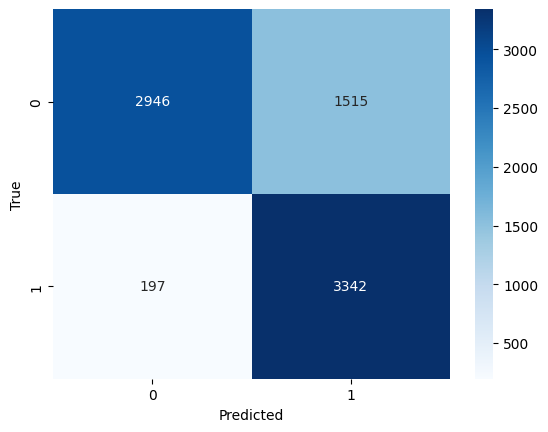

In [10]:
from transformers import get_scheduler

# Load and prepare data
train_dataset = SiameseDataset(train_data, tokenizer)
val_dataset = SiameseDataset(val_data, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Initialize model
model = SiameseClassifier(model_name=model_name)

# Train
train_model(model, train_loader, val_loader, epochs=5, lr=2e-5)

# Load and evaluate
model.load_state_dict(torch.load("best_siamese_classifier.pt"))
evaluate_model(model, val_loader)
